In [380]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt
from qiskit.synthesis import SuzukiTrotter

In [549]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

n = 2
H_XY = np.zeros((2**n, 2**n), dtype=np.complex128)

for i in range(n-1):
    H_XY += np.kron(X, X) + np.kron(Y, Y)
# H_XY /= np.linalg.norm(H_XY, 2)

In [550]:
eigenvalues, eigenvectors = np.linalg.eig(H_XY)

# Print the original matrix
print("Hamiltonian:")
print(H_XY)

# Print the eigenvalues
print("\nEigenvalues:")
for i, eigenvalue in enumerate(eigenvalues):
    print(f"Eigenvalue {i+1}: {eigenvalue}")

# Print the eigenvectors
print("\nEigenvectors:")
for i, eigenvector in enumerate(eigenvectors.T):
    print(f"Eigenvector {i+1}: {eigenvector}")

Hamiltonian:
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

Eigenvalues:
Eigenvalue 1: (2+0j)
Eigenvalue 2: (-2+0j)
Eigenvalue 3: 0j
Eigenvalue 4: 0j

Eigenvectors:
Eigenvector 1: [-0.        -0.j  0.70710678-0.j  0.70710678+0.j -0.        -0.j]
Eigenvector 2: [-0.        -0.j -0.70710678-0.j  0.70710678+0.j -0.        -0.j]
Eigenvector 3: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Eigenvector 4: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


In [551]:
tf = 50
dt = 0.5
Nt = int(tf / dt)
# Nt = 22
c = ['1','0'] 
# c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]

UnitVector = lambda c: np.eye(2**n)[c]
init = UnitVector(int(''.join(c), 2))

exact_te = [expm_multiply(-1j * H_XY * t, init) for t in np.linspace(0, tf, Nt)]

In [554]:
def ExactEvolve(dt, nt, init):
    U = expm(-1j * H_XY * dt)

    exact = [np.zeros(2**n) for i in range(nt+1)]
    exact[0] = init
    for i in range(nt):
        exact[i+1] = U @ exact[i]
    return exact

def TrotterEvolve(dt, nt, init):
    XX = expm(-1j * dt * np.kron(X,X))
    YY = expm(-1j * dt * np.kron(Y,Y))
    UTrot = XX @ YY

    trot = [np.zeros(2**n) for i in range(nt+1)]
    trot[0] = init
    for i in range(nt):
        trot[i+1] = UTrot @ trot[i]
    return trot

trot_te = TrotterEvolve(dt, Nt, init)
exact_te = ExactEvolve(dt, Nt, init)
# U_trot = lambda t : expm(-1j * t * np.kron(X,X)) @ expm(-1j * t * np.kron(Y,Y))
# trot_te = [(U_trot(float(t)) @ init) for t in np.linspace(0, tf, Nt)]

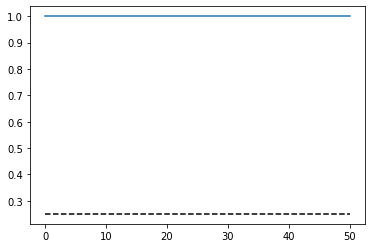

In [555]:
overlap = [np.abs(np.conj(psi) @ phi)**2 for psi,phi in zip(exact_te, trot_te)]
# overlap = [np.abs(np.conj(psi) @ np.outer(init, init) @ psi)**2 for psi in revos]

maximally = [abs(np.conj(np.array([1/2,1/2,1/2,1/2])) @ psi)**2 for psi in exact_te]

plt.plot([i*dt for i in range(len(exact_te))], overlap)
plt.plot([i*dt for i in range(len(exact_te))], maximally, 'k--')

# plt.axhline(y=0, color='k')

In [253]:
init = np.array([1/np.sqrt(2),0,1/np.sqrt(2),0])
# init = np.array([0,1,0,0])
# init = UnitVector(int(''.join(['1','0']), 2))


dt = 10
Ut = expm(-1j * dt * np.kron(X,X)) @ expm(-1j * dt * np.kron(Y,Y))
U = expm(-1j * dt * H_XY)
krylov = [init, U @ init, (U @ U) @ init, (U @ U @ U) @ init]

krylov

[array([0.70710678, 0.        , 0.70710678, 0.        ]),
 array([ 0.70710678+0.j        ,  0.        +0.38468102j,
        -0.59331317+0.j        ,  0.        +0.j        ]),
 array([0.70710678+0.j        , 0.        -0.64554978j,
        0.28855759+0.j        , 0.        +0.j        ]),
 array([0.70710678+0.j        , 0.        +0.69864386j,
        0.10907225+0.j        , 0.        +0.j        ])]

In [254]:
def Gramian(krylov):
    k = len(krylov)
    gramian = np.zeros((k,k))
    
    for i in range(k):
        for j in range(k):
            gramian[i][j] = np.conj(krylov[i]) @ krylov[j]

    return gramian

np.linalg.det(Gramian(krylov))

In [524]:
np.round(expm(-1j * H_XY * dt), 2)

array([[1.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.88+0.j  , 0.  -0.48j, 0.  +0.j  ],
       [0.  +0.j  , 0.  -0.48j, 0.88+0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 1.  +0.j  ]])

In [527]:
np.round(U_trot(dt), 2)

array([[1.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  -0.j  ],
       [0.  +0.j  , 0.54+0.j  , 0.  -0.84j, 0.  +0.j  ],
       [0.  +0.j  , 0.  -0.84j, 0.54+0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 1.  +0.j  ]])